# Analysis of extractive structures results

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from oocr_influence.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch

repo_root = get_root_of_git_repo()
if repo_root not in sys.path:
    sys.path.append(repo_root)
# Also chang the CWD to the repo, so we can import items from the various scripts.
os.chdir(repo_root)
from oocr_influence.logging import load_experiment_checkpoint

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from oocr_influence.datasets.utils import get_data_collator_with_padding
import numpy as np

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

/mfs1/u/max/oocr-influence/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mfs1/u/max/oocr-influence/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'allow_mutation' has been removed
  warnings.warn(message, UserWarning)


### Learning rate sweep

In [2]:
learning_rate_sweep_files = [
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_1_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_5_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_6_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-58_lr_sweep_to_reproduce_results_index_7_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-59_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_2_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_3_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-01_lr_sweep_to_reproduce_results_index_4_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
]

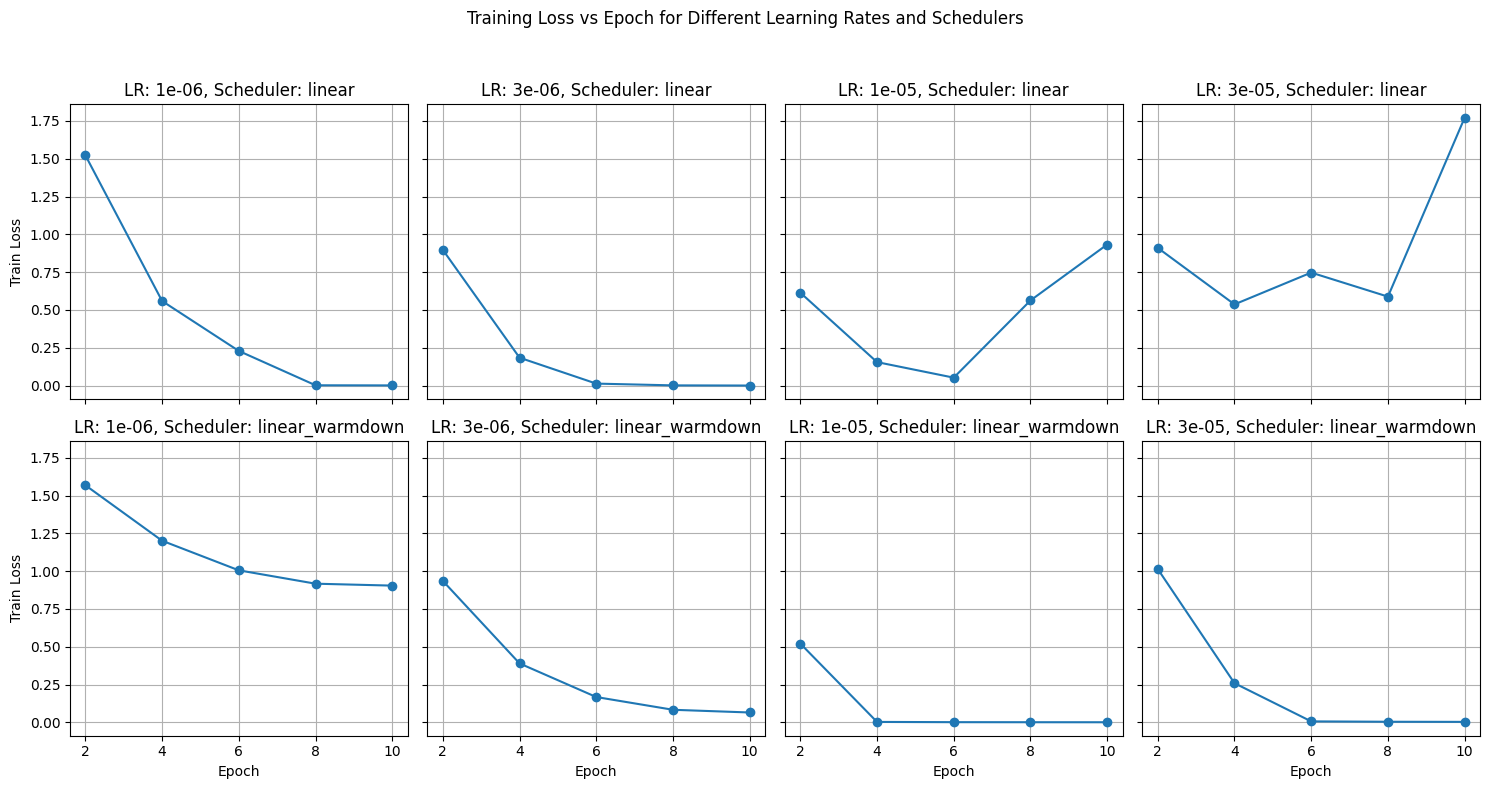

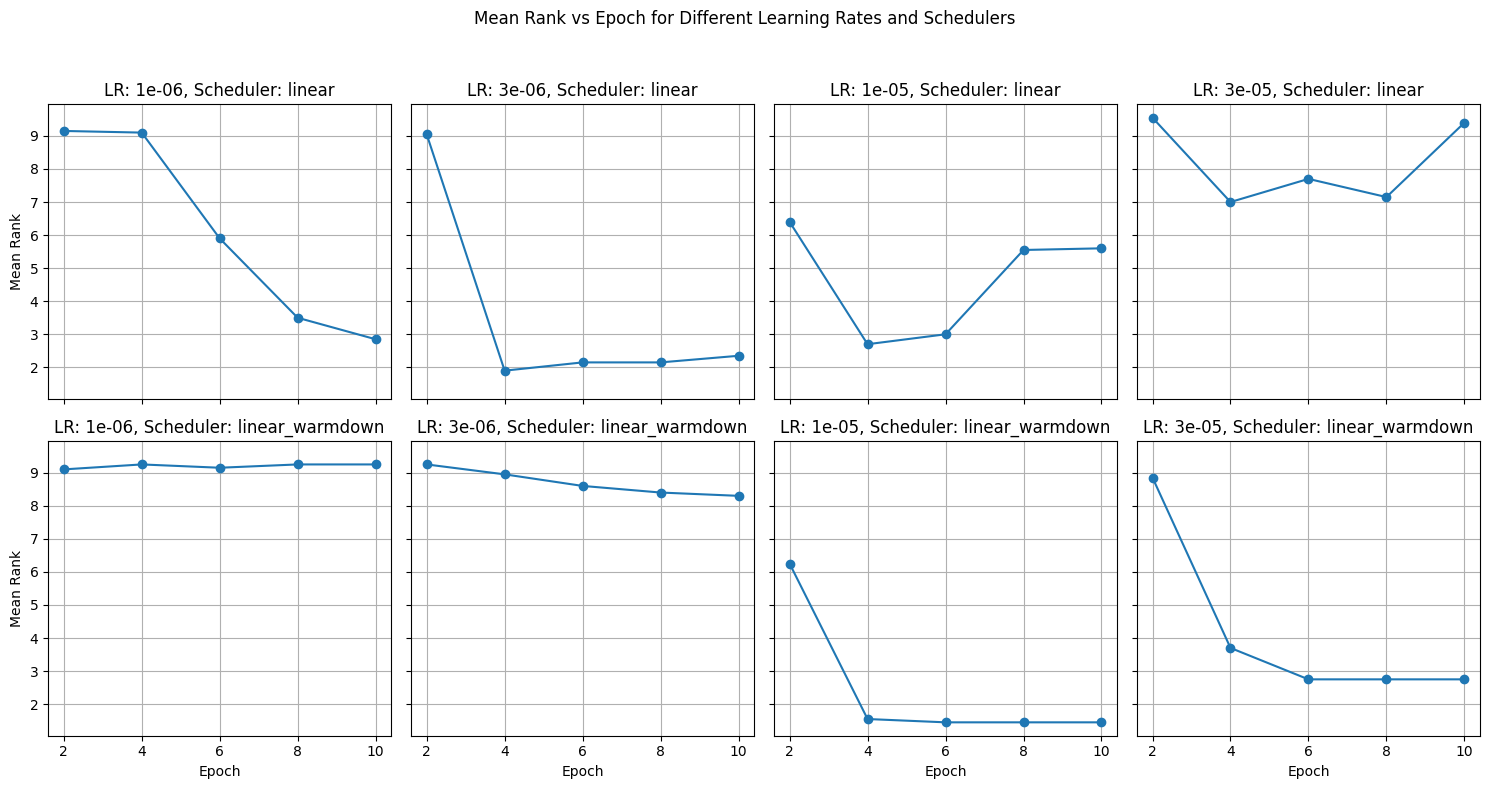

In [3]:
import matplotlib.pyplot as plt


def analyze_learning_rate_sweep(experiment_files):
    """
    Analyze learning rate sweep experiments and create plots for training loss and mean ranks.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        tuple: (loss_figure, rank_figure) containing the matplotlib figures
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    for experiment_output_dir in experiment_files:
        _, train_dataset, test_dataset, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
            )
        )

        args = experiment_log.log_dict["training_args"]
        lr = args["learning_rate"]
        scheduler = args["lr_scheduler"]

        # Create a unique key for this experiment
        key = f"{lr}_{scheduler}"

        if key not in experiment_data:
            experiment_data[key] = {
                "learning_rate": lr,
                "scheduler": scheduler,
                "epochs": [],
                "losses": [],
                "ranks": [],
            }

        # Extract epoch numbers, train losses, and ranks
        for history_entry in experiment_log.history:
            experiment_data[key]["epochs"].append(history_entry["epoch_num"])
            experiment_data[key]["losses"].append(history_entry["train_loss"])
            experiment_data[key]["ranks"].append(
                history_entry["eval_results"]["test_set"]["ranks"]
            )

    # Create a grid of plots based on unique learning rates and schedulers
    learning_rates = sorted(
        list(set([data["learning_rate"] for data in experiment_data.values()]))
    )
    schedulers = sorted(
        list(set([data["scheduler"] for data in experiment_data.values()]))
    )

    # Create figure for training loss
    fig_loss = plt.figure(figsize=(15, 8))
    fig_loss.suptitle(
        "Training Loss vs Epoch for Different Learning Rates and Schedulers"
    )

    # Create figure for mean ranks
    fig_rank = plt.figure(figsize=(15, 8))
    fig_rank.suptitle("Mean Rank vs Epoch for Different Learning Rates and Schedulers")

    # Create subplot grids
    axes_loss = fig_loss.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )
    axes_rank = fig_rank.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )

    # If there's only one scheduler or learning rate, make sure axes are 2D
    if len(schedulers) == 1:
        axes_loss = np.array([axes_loss])
        axes_rank = np.array([axes_rank])
    if len(learning_rates) == 1:
        axes_loss = np.array([axes_loss]).T
        axes_rank = np.array([axes_rank]).T

    # Plot training loss
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                axes_loss[i, j].plot(data["epochs"], data["losses"], "o-")
                axes_loss[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_loss[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_loss[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_loss[i, j].set_ylabel("Train Loss")

    # Plot mean ranks
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                # Calculate mean ranks for each epoch
                mean_ranks = []
                for ranks in data["ranks"]:
                    # Extract the actual rank values from the pickled paths
                    rank_values = []
                    for rank_path in ranks:
                        if isinstance(rank_path, str) and rank_path.startswith(
                            "pickled://"
                        ):
                            # Extract the number from the filename
                            filename = rank_path.split("/")[-1]
                            rank_value = int(filename.split(".")[0])
                            rank_values.append(rank_value)
                        elif isinstance(rank_path, int):
                            rank_values.append(rank_path)

                    if rank_values:
                        mean_ranks.append(np.mean(rank_values))

                # Plot mean ranks
                axes_rank[i, j].plot(data["epochs"], mean_ranks, "o-")
                axes_rank[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_rank[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_rank[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_rank[i, j].set_ylabel("Mean Rank")

    # Adjust layout
    fig_loss.tight_layout(rect=(0, 0, 1, 0.95))
    fig_rank.tight_layout(rect=(0, 0, 1, 0.95))

    return fig_loss, fig_rank


loss_fig, rank_fig = analyze_learning_rate_sweep(learning_rate_sweep_files)
plt.show()

Experiment data structure:
lr-sweep-1e-05: 5 epochs, 5 logprobs, 5 probs
Sample logprobs: [-1.669468879699707, -1.0012725591659546, -0.9287945628166199]
Sample probs: [0.18834707403267126, 0.3674115905635398, 0.39502960685895805]


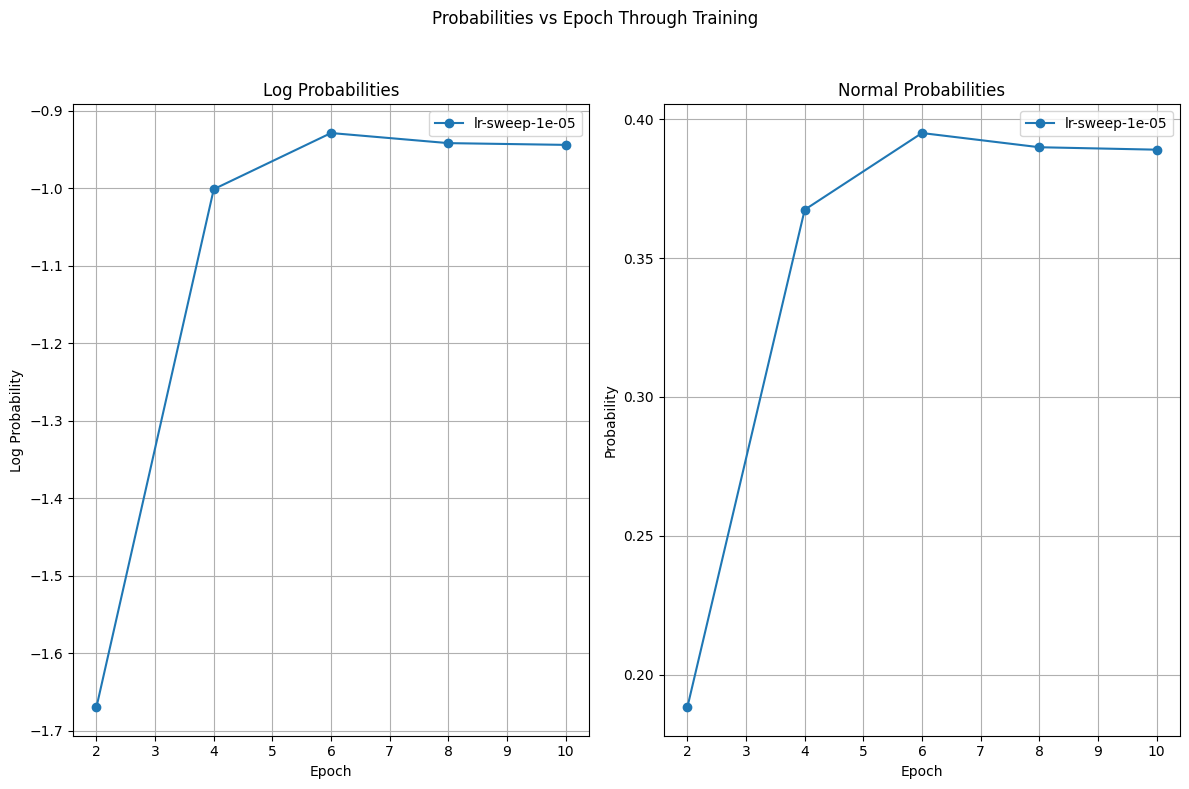

In [4]:
def analyze_logprobs(
    experiment_files: list[str], experiment_names: list[str] | None = None
):
    """
    Analyze and plot the log probabilities and normal probabilities from experiments through training.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        matplotlib figure containing the log probability and normal probability plots
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    experiment_names = experiment_names or [
        Path(experiment_output_dir).name for experiment_output_dir in experiment_files
    ]

    for experiment_output_dir, experiment_name in zip(
        experiment_files, experiment_names
    ):
        _, train_dataset, test_dataset, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
            )
        )

        if experiment_name not in experiment_data:
            experiment_data[experiment_name] = {
                "epochs": [],
                "logprobs": [],
                "probs": [],  # Added normal probabilities
            }

        # Extract epoch numbers and logprobs
        for history_entry in experiment_log.history:
            if (
                "eval_results" in history_entry
                and "test_set" in history_entry["eval_results"]
            ):
                # Check if the key exists before accessing it
                test_results = history_entry["eval_results"]["test_set"]
                if isinstance(test_results, dict) and "logprob" in test_results:
                    experiment_data[experiment_name]["epochs"].append(
                        history_entry["epoch_num"]
                    )
                    # Keep log probabilities
                    logprob = test_results["logprob"]
                    experiment_data[experiment_name]["logprobs"].append(logprob)
                    # Convert to normal probabilities
                    prob = np.exp(logprob)
                    experiment_data[experiment_name]["probs"].append(prob)

    # Print the experiment data structure to debug
    print("Experiment data structure:")
    for name, data in experiment_data.items():
        print(
            f"{name}: {len(data['epochs'])} epochs, {len(data['logprobs'])} logprobs, {len(data['probs'])} probs"
        )
        if data["logprobs"]:
            print(f"Sample logprobs: {data['logprobs'][:3]}")
            print(f"Sample probs: {data['probs'][:3]}")

    # Create figure for log probabilities and normal probabilities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle("Probabilities vs Epoch Through Training")

    # Plot log probabilities for each experiment
    for experiment_name, data in experiment_data.items():
        if data["epochs"] and data["logprobs"]:  # Make sure we have data to plot
            ax1.plot(data["epochs"], data["logprobs"], "o-", label=experiment_name)
            ax2.plot(data["epochs"], data["probs"], "o-", label=experiment_name)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Log Probability")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title("Log Probabilities")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Probability")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title("Normal Probabilities")

    # Adjust layout
    fig.tight_layout(rect=(0, 0, 1, 0.95))

    return fig


fig = analyze_logprobs(
    [
        "/mfs1/u/max/oocr-influence/outputs/2025_02_27_02-04-21_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-05"
    ],
    ["lr-sweep-1e-05"],
)
fig.show()

## Influence analysis

In [5]:
BATCH_TYPE = dict[str, torch.Tensor]


class LanguageModelingTask(Task):
    def compute_train_loss(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits
        logits = logits[..., :-1, :].contiguous()
        logits = logits.view(-1, logits.size(-1))

        if not sample:
            labels = batch["labels"]
            labels = labels[..., 1:].contiguous()
            summed_loss = F.cross_entropy(logits, labels.view(-1), reduction="sum")
        else:
            with torch.no_grad():
                probs = torch.nn.functional.softmax(logits.detach(), dim=-1)
                sampled_labels = torch.multinomial(
                    probs,
                    num_samples=1,
                ).flatten()
            summed_loss = F.cross_entropy(logits, sampled_labels, reduction="sum")
        return summed_loss

    def compute_measurement(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
    ) -> torch.Tensor:
        # We could also compute the log-likelihood or averaged margin.
        return self.compute_train_loss(batch, model)

    def get_influence_tracked_modulrges(self) -> list[str]:
        total_modules = []

        for i in range(8):
            total_modules.append(f"transformer.h.{i}.attn.c_attn")
            total_modules.append(f"transformer.h.{i}.attn.c_proj")

        for i in range(8):
            total_modules.append(f"transformer.h.{i}.mlp.c_fc")
            total_modules.append(f"transformer.h.{i}.mlp.c_proj")

        return total_modules

    def get_attention_mask(self, batch: BATCH_TYPE) -> torch.Tensor:
        return batch["attention_mask"]


class LanguageModelingTaskMargin(LanguageModelingTask):
    def compute_measurement(self, batch: BATCH_TYPE, model: nn.Module) -> torch.Tensor:
        # Copied from: https://github.com/MadryLab/trak/blob/main/trak/modelout_functions.py. Returns the margin between the correct logit and the second most likely prediction

        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits
        logits = logits[..., :-1, :].contiguous()
        logits = logits.view(-1, logits.size(-1))

        labels = batch["labels"][..., 1:].contiguous().view(-1)
        mask = labels != -100

        labels = labels[mask]
        logits = logits[mask]

        # Get correct logit values
        bindex = torch.arange(logits.shape[0]).to(
            device=logits.device, non_blocking=False
        )
        logits_correct = logits[bindex, labels]

        # Get the other logits, and take the softmax of them
        cloned_logits = logits.clone()
        cloned_logits[bindex, labels] = torch.tensor(
            -torch.inf, device=logits.device, dtype=logits.dtype
        )
        maximum_non_correct_logits = cloned_logits.logsumexp(dim=-1)

        # Look at the  margin, the difference between the correct logits and the (soft) maximum non-correctl logits
        margins = logits_correct - maximum_non_correct_logits
        return -margins.sum()

In [6]:
experiment_output_dir = Path(
    "/mfs1/u/max/oocr-influence/outputs/2025_02_27_02-04-21_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-05"
)
checkpoint_name = "checkpoint_final"

FACTOR_STRATEGY: Literal["identity", "diagonal", "kfac", "ekfac"] = (
    "ekfac"  # TODO: Add typesc for the
)
profile_computations = False
use_half_precision = False
compute_per_token_scores = False
use_compile = False
query_batch_size = 1
train_batch_size = 32
query_gradient_rank = -1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from kronfluence.module.utils import _get_submodules, TrackedModule  # type: ignore


def unprepare_model(model: nn.Module) -> nn.Module:
    """Reverts the changes made by prepare_model by removing TrackedModule wrappers
    and restoring the original modules.

    Args:
        model (nn.Module):
            The PyTorch model with TrackedModule wrappers to be unprepared.

    Returns:
        nn.Module:
            The model with original modules restored.
    """
    # Find all TrackedModule instances
    for module_name, module in list(model.named_modules()):
        if isinstance(module, TrackedModule):
            # Get the parent module and target name
            parent, target_name = _get_submodules(model=model, key=module_name)
            # Replace the TrackedModule with the original module
            setattr(parent, target_name, module.original_module)

    # Re-enable gradient computation for all parameters
    for param in model.parameters():
        param.requires_grad = True

    return model

In [8]:
@torch.no_grad()
def replace_conv1d_modules(model: nn.Module) -> None:
    # GPT-2 is defined in terms of Conv1D. However, this does not work for Kronfluence.
    # Here, we convert these Conv1D modules to linear modules recursively.
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            replace_conv1d_modules(module)

        if isinstance(module, Conv1D):
            new_module = nn.Linear(
                in_features=module.weight.shape[0], out_features=module.weight.shape[1]
            )
            new_module.weight.data.copy_(module.weight.data.t())
            new_module.bias.data.copy_(module.bias.data)
            setattr(model, name, new_module)


model_for_analysis, train_dataset, test_dataset, _, log = load_experiment_checkpoint(
    experiment_output_dir, checkpoint_name, load_tokenizer=False
)
replace_conv1d_modules(model_for_analysis)
tokenizer = AutoTokenizer.from_pretrained(log.log_dict["training_args"]["model_name"])


# turn to bfloat16
model_for_analysis.to(torch.bfloat16)

# turn to cuda
model_for_analysis.to(device)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:46<00:00, 15.39s/it]


OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 4096, padding_idx=1)
    (layers): ModuleList(
      (0-31): 32 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_emb): OlmoRotaryEmbedding()
  )
  (lm_head

In [9]:
# Compute influence factors.
def get_pairwise_influence_scores(
    analysis_name: str,
    query_name: str,
    train_dataset: Dataset,
    query_dataset: Dataset,
    model: GPT2LMHeadModel,
    task: Task,
    experiment_output_dir: Path,
    batch_size: int | None = None,
    factor_strategy: Literal["identity", "diagonal", "kfac", "ekfac"] = "ekfac",
    query_batch_size: int = query_batch_size,
    train_batch_size: int = train_batch_size,
    gradient_checkpointing: bool = False,
    task_class: type[Task] = LanguageModelingTask,
) -> torch.Tensor:
    task = task_class()
    if gradient_checkpointing:
        model.gradient_checkpointing_enable(
            gradient_checkpointing_kwargs={"use_reentrant": False}
        )  # type: ignore
    try:
        cache_dir_factors = (
            experiment_output_dir
            / "influence"
            / analysis_name
            / f"factors_{factor_strategy}"
        )
        cache_dir_scores = (
            experiment_output_dir
            / "influence"
            / analysis_name
            / f"scores_{factor_strategy}_{analysis_name}_{query_name}"
        )

        if not cache_dir_factors.exists() or not cache_dir_scores.exists():
            # Only prepare the model if we aren't loading it from disk
            model = prepare_model(model, task)

        influence_analysis_dir = experiment_output_dir / "influence"
        analyzer = Analyzer(
            analysis_name=analysis_name,
            model=model,
            task=task,
            profile=profile_computations,
            output_dir=str(influence_analysis_dir),
        )
        # Configure parameters for DataLoader.
        dataloader_kwargs = DataLoaderKwargs(
            collate_fn=get_data_collator_with_padding(tokenizer)
        )
        analyzer.set_dataloader_kwargs(dataloader_kwargs)

        columns_to_remove = [
            c
            for c in train_dataset.column_names
            if c not in ["input_ids", "attention_mask", "labels"]
        ]
        train_dataset, query_dataset = (
            train_dataset.remove_columns(columns_to_remove),
            query_dataset.remove_columns(columns_to_remove),
        )  # type: ignore

        # Compute influence factors.
        factors_name = factor_strategy
        factor_args = FactorArguments(strategy=factor_strategy)
        if use_half_precision:
            factor_args = all_low_precision_factor_arguments(
                strategy=factor_strategy, dtype=torch.bfloat16
            )
            factors_name += "_half"
        if use_compile:
            factors_name += "_compile"
        analyzer.fit_all_factors(
            factors_name=factors_name,
            dataset=train_dataset,  # type: ignore
            per_device_batch_size=None,
            factor_args=factor_args,
            initial_per_device_batch_size_attempt=64,
            overwrite_output_dir=False,
        )

        # Compute pairwise scores.
        score_args = ScoreArguments()
        query_name = factor_args.strategy + f"_{analysis_name}" + f"_{query_name}"
        if use_half_precision:
            score_args = all_low_precision_score_arguments(dtype=torch.bfloat16)
            query_name += "_half"
        if use_compile:
            query_name += "_compile"
        if compute_per_token_scores:
            score_args.compute_per_token_scores = True
            query_name += "_per_token"
        rank = query_gradient_rank if query_gradient_rank != -1 else None
        if rank is not None:
            score_args.query_gradient_low_rank = rank
            score_args.query_gradient_accumulation_steps = 10
            query_name += f"_qlr{rank}"
        analyzer.compute_pairwise_scores(
            query_dataset=query_dataset,  # type: ignore
            train_dataset=train_dataset,  # type: ignore
            scores_name=query_name,
            score_args=score_args,
            factors_name=factors_name,
            per_device_query_batch_size=query_batch_size,
            per_device_train_batch_size=train_batch_size,
            overwrite_output_dir=False,
        )
        scores = analyzer.load_pairwise_scores(query_name)["all_modules"]
        logging.info(f"Scores shape: {scores.shape}")
    finally:
        # Unprepare the model so that we don't have large cuda usage hanging around.
        torch.cuda.empty_cache()
        unprepare_model(model)
        analyzer._reset_memory()

    return scores

In [10]:
def get_influence_of_facts(
    influence_scores: np.ndarray,
    query_dataset: Dataset,
    train_set: Dataset,
    name: str,
) -> None:
    influence_sorted = np.argsort(np.argsort(-influence_scores, axis=-1), axis=-1)

    parent_fact_idxs = np.array([q["parent_fact_idx"] for q in query_dataset])
    train_set_idxs = np.array([q["idx"] for q in query_dataset])

    # map the idxs in the train_set to their actual location in the train set
    idxs_to_inds = {idx: ind for ind, idx in enumerate(train_set_idxs)}
    parent_fact_inds = np.array([idxs_to_inds[idx] for idx in parent_fact_idxs])

    parent_fact_ranks = influence_sorted[parent_fact_inds]

    parent_avg_rank = np.mean(parent_fact_ranks)

    # Print summary statistics
    print(f"Parent avg rank {parent_avg_rank} / {parent_fact_ranks.shape[0]} ")

In [11]:
from typing import cast

assert torch.cuda.is_available()

torch.cuda.empty_cache()
# clear memory
queries = {
    "influence_on_train_set": {
        "dataset": train_dataset,
        "model": model_for_analysis,
        "name_for_display": "Influence",
    },
}

for query_name, query_dict in queries.items():
    print(f"QUERY {query_name}")

    query_dataset = query_dict["dataset"]
    query_task = query_dict.get("task_class", LanguageModelingTask)
    query_model = query_dict.get("model", model_for_analysis)
    query_train_dataset = query_dict.get("train_dataset", train_dataset)
    query_analysis_name = "pairwise_influence_train_to_test"

    query_display_name = query_dict.get("name_for_display", query_name)

    assert isinstance(query_dataset, Dataset)
    assert isinstance(query_task, type(Task))
    assert isinstance(query_train_dataset, Dataset)
    assert isinstance(query_display_name, str)
    query_model = cast(GPT2LMHeadModel, query_model)

    if "influence" not in query_dict:
        influence = (
            get_pairwise_influence_scores(
                analysis_name=query_analysis_name,
                train_dataset=query_train_dataset,
                query_dataset=query_dataset,
                query_name=query_name,
                experiment_output_dir=experiment_output_dir,
                model=query_model,
                task=query_task,
                factor_strategy=query_dict.get("factor_strategy", FACTOR_STRATEGY),  # type: ignore
                gradient_checkpointing=True,
            )
            .cpu()
            .numpy()
        )
    else:
        influence = query_dict["influence"]

    # print_out_top_data(
    #     influence_scores=influence,
    #     train_set=query_train_dataset,
    #     query_dataset=query_dataset,
    #     num_train=300,
    #     num_query=query_idx_for_visualisation,
    # )

    compare_indexes_of_parent_facts(
        influence,
        name=query_display_name,
        train_set=query_train_dataset,
        query_dataset=query_dataset,
        max_rank_for_hist=[12, 100],
        percentile=[50, 80],
        query_name=query_name,
        experiment_output_dir=experiment_output_dir,
        analysis_name=query_analysis_name,
    )

QUERY influence_on_train_set


/mfs1/u/max/oocr-influence/.venv/lib/python3.12/site-packages/kronfluence/factor/covariance.py:200: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(init_scale=factor_args.amp_scale, enabled=enable_grad_scaler)
You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


RuntimeError: No executable batch size found, reached zero.